In [1]:
import pandas as pd
import os

First, define the report/meta data file locations

In [2]:
ROOT = '/media/matt/data21/datasets/mimic-cxr/data'

labels = pd.read_csv(os.path.join(ROOT, 'mimic-cxr-2.0.0-chexpert.csv.gz'))
records = pd.read_csv(os.path.join(ROOT, 'cxr-record-list.csv.gz'))
studies = pd.read_csv(os.path.join(ROOT, 'cxr-study-list.csv.gz'))
metadata = pd.read_csv(os.path.join(ROOT, 'mimic-cxr-2.0.0-metadata.csv.gz'))


There is no one format for the radiologist report. We need to standardise our text inputs, with the aim to contain the most relevant string of text. Furthermore, computing constraints limit our sequence input to a maximum of around 50 characters. 

In [6]:
studies['report'] = studies.path.apply(lambda x: ' '.join([line.strip() for line in open(os.path.join(ROOT,'mimic-cxr-reports',x))]))

In [7]:
rs = records.merge(studies[['study_id','report']], how='left', on='study_id')
# rs.rename(columns={'subject_id_x':'subject_id', 'path_x':'path_img', 'path_y':'path_report'}, inplace=True)
# rs.drop(columns='subject_id_y', inplace=True)

In [8]:
rs = rs.merge(metadata[['dicom_id','ViewPosition']], on='dicom_id', how='left')

In [5]:
# rs = rs.merge(labels.iloc[:,1:], on='study_id')

In [10]:
import re
# Some text cleaning
def sanitize(text):
    text = text.strip()
    text = re.sub("\n", "", text)
    text = re.sub(",", "", text)
    # Remove all text before FINDINGS: section
    r = r'^(.*finding.?:)|^(.*impression.?:)'

    # TODO: comment if want to filter on impressions (not findings)
    if( re.search(r, text, flags=re.IGNORECASE)==None ): #if no summary
        return None

    text = re.sub(r,"", text, flags=re.IGNORECASE)
    # Move impression to start of report; when truncating to max_seq_len
    # want to keep this summary
    try:
        r2 = r'(impression.?:.*)'
        impressions = re.findall(r2, text, flags=re.IGNORECASE)[0]
        imp_len = len(impressions) - len('impression:')
        text = re.findall(r2, text, flags=re.IGNORECASE)[0] + text
        text = text[:-imp_len]
    except:
        pass
    # Now remove the word 'impression' (optional)
    r3 = r'(impression.?:)'
    text = re.sub(r3,"", text, flags=re.IGNORECASE)
    return(text)


In [11]:
rs['report'] = rs.report.apply(sanitize)

In [12]:
rs.report.fillna("", inplace=True)
rs['report_len'] = rs.report.apply(str.split).apply(len)

There's now clean report text, with impressions (if any) first, and 

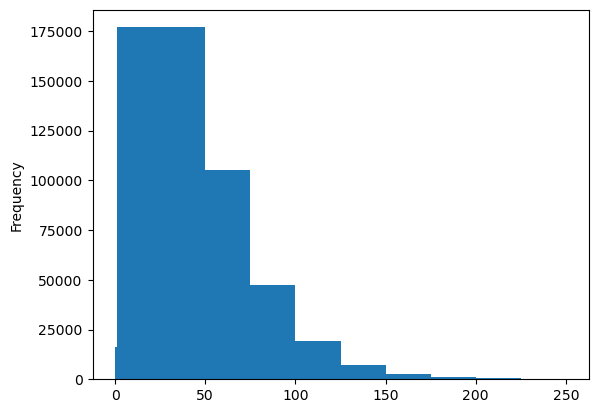

In [13]:
import matplotlib.pyplot as plt
ax = rs.report_len.plot.hist(bins=[0,1,50,75,100,125,150,175,200,225,250])
plt.show()

In [49]:
print(len(rs[(rs.report_len!=0) & (rs.ViewPosition=='AP')]))
print(len(rs[(rs.report_len!=0) & ((rs.ViewPosition=='AP') | (rs.ViewPosition=='PA'))]))
# 138k vs. 231k

138166
231424


In [50]:
rs_AP = rs[(rs.report_len!=0) & (rs.ViewPosition=='AP')].copy()

In [51]:
# Optional: 
rs_AP_nodup = rs_AP.drop_duplicates(subset='study_id') # 138,000 -> 124,000

In [57]:
df = rs_AP_nodup

In [61]:
from skmultilearn.model_selection import iterative_train_test_split, IterativeStratification
def stratify(x,y,split=0.05):
    """x: numpy array of indices
       y: numpy array of multi labels
       split: ratio of split
       returns: stratified split indices"""
    split = int(1/split)
    stratifier = IterativeStratification(n_splits=split, order=4)
    train_idx, test_idx = next(stratifier.split(x, y))
    return train_idx, test_idx

In [46]:
# Clean up the labels, replace uncertain with none
labels = labels.fillna(0).convert_dtypes() # Replace Na with 0
labels = labels.replace(to_replace=-1,value=0)
labels.loc[labels.iloc[:,2:].sum(axis=1)<1, 'No Finding'] = 1  # Optional; set no finding for blanks (10k)
# Drop no finding as per other study
labels = labels.drop(columns='No Finding')

In [59]:
df = df.merge(labels[labels.columns[1:]], on='study_id', how='left')

In [90]:
# Split train off
x = df.index.values.astype(int)
y = df[df.columns[8:]].values.astype(int)

train_idx, test_idx = stratify(x,y,0.1)


In [91]:
# Split test into val:test
x = df.iloc[test_idx,:].index.values.astype(int)
y = df.iloc[test_idx,8:].values.astype(int)

val_idx, test_idx = stratify(x, y, 0.5)



In [92]:
for idx in (train_idx, val_idx, test_idx):
    print(len(idx))

112124
6229
6229


In [120]:
train_set = df.iloc[train_idx]['dicom_id'].reset_index()
val_set = df.iloc[val_idx]['dicom_id'].reset_index()
test_set = df.iloc[test_idx]['dicom_id'].reset_index()

train_set.loc[:,'split']='TRAIN'
val_set.loc[:,'split']='VAL'
test_set.loc[:,'split']='TEST' 

split_df = pd.concat([train_set, val_set, test_set], axis=0).drop(columns='index')
split_df = split_df.merge(df, on='dicom_id', how='left').reset_index().drop(columns='index')

# Also need to replace .dcm with .jpg extension
split_df.loc[:,'path'] = split_df.path.apply(lambda x: x[:-3]+'jpg')

split_df.to_csv(os.path.join(ROOT, 'studies_with_splits.csv'), index=False)

In [105]:
df.drop(columns=['report_clean'], inplace=True)

In [ ]:
# ## Assess strat combos:
# from skmultilearn.model_selection.measures import get_combination_wise_output_matrix
# from collections import Counter
# counts = Counter(combination for row in get_combination_wise_output_matrix(y.values, order=4) for combination in row)
# counts.most_common()[::-1]
# # Order 4 yields combinations with 1 sample, this is enough?

In [1]:
import pandas as pd

In [5]:
df = pd.read_csv(os.path.join(os.path.join(ROOT, 'studies_with_splits.csv')))

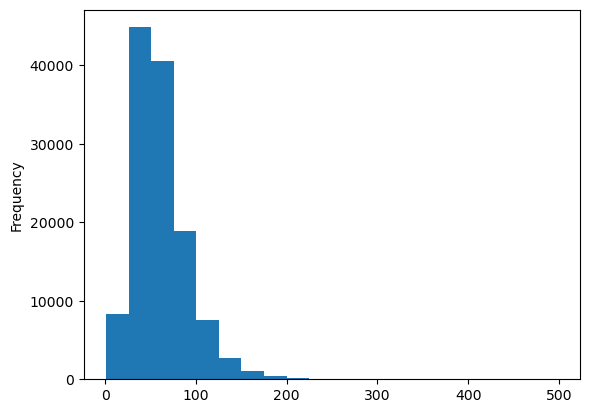

In [8]:
import matplotlib.pyplot as plt

df['report_len'].plot.hist(bins=20)
plt.show()

In [ ]:
import re
reg = re.compile(r'')